# Read Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from urban_growth.estimator import *
from urban_growth.components import *
from itertools import product
import pandas as pd
import pickle
from scipy.special import expit
%matplotlib inline

In [2]:
years      = [1990, 2000, 2010, 2015]
throughput_dir = 'throughput'

plot_args = {'interpolation' : 'nearest', 'cmap' : 'Greys'}

In [3]:
def f(x, delim):
    path = throughput_dir + '/HCM_' + str(x) + '.txt'
    print 'reading ' + path
    return np.loadtxt(path, dtype=int, delimiter=delim)

maps  = {year : f(year, ' ') for year in years}
geo = np.loadtxt(throughput_dir + '/HCM_geo.txt')

reading throughput/HCM_1990.txt
reading throughput/HCM_2000.txt
reading throughput/HCM_2010.txt
reading throughput/HCM_2015.txt


In [4]:
maps = {year : sum([maps[i] for i in years if i <= year]) for year in years}
for k in maps:
    maps[k][maps[k] > 1] = 1

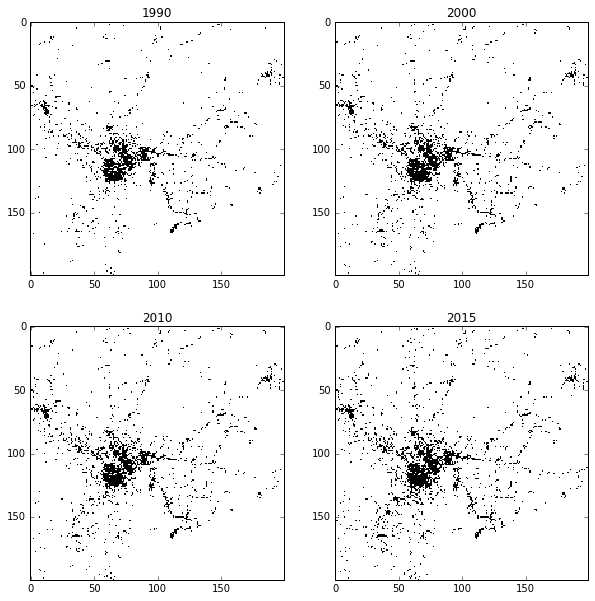

In [5]:
fig, axarr = plt.subplots(2, 2, figsize = (10, 10))
k = 0
for i, j in product(range(2), range(2)):
    axarr[i, j].imshow(maps[years[i + j]], **plot_args)
    axarr[i,j].set_title(years[k])
    k += 1

# Perform Inference

In [6]:
def grid_search(Y0, Y1):
   
    y0_vec= []
    y1_vec = []
    T_vec = []
    pars_hat_vec = []
    ll_vec = []
    h_inv_vec = []
    N_vec = []

    X = maps[Y1] - maps[Y0]
    X[X == -1] = 0          # ignore settlements that have been disbanded
    X = X * geo             # make consistent with geo mask
    X[maps[Y0]] = np.nan
    
    e = estimator(M0 = maps[Y0], geo = geo, model = 'logistic')
    e.update_morphology()
    e.make_dist_array()
    
#     for T in sorted(set(e.areas.values()))[1:]:
    for T in np.arange(1, 10):
        e.partition_clusters([T])
        e.partition_dist_array()
        pars_0 = {
            'alpha' : np.array([5, 8]),
            'gamma' : np.array([3.5, 2.8]), 
            'beta'  : np.array([-2])
           }

        pars_hat, ll_hat, h_inv = e.logistic_ML(X, 
                                        pars_0, 
                                        use_grad = True, 
                                        opts = {'disp' : True})
        
        y0_vec.append(Y0)
        y1_vec.append(Y1)
        T_vec.append(T)
        pars_hat_vec.append(pars_hat)
        ll_vec.append(ll_hat)
        h_inv_vec.append(h_inv)
        N_vec.append(np.sum(np.isfinite(X) * (geo > 0)))
                
        print T, pars_hat
        
    df = pd.DataFrame(
            {
                'Y0'       : y0_vec,
                'Y1'       : y1_vec,
                'T'        : T_vec,
                'pars_hat' : pars_hat_vec,
                'll'       : ll_vec,
                'h_inv'    : h_inv_vec,
                'N'        : N_vec
            }
        )
    return df
    

In [7]:
out = pd.concat([grid_search(years[i], years[i+1]) for i in range(3)])

Optimization terminated successfully.
         Current function value: 0.044064
         Iterations: 50
         Function evaluations: 54
         Gradient evaluations: 54
1 [  5.          33.39708336   3.5          3.7069086   -4.83038664]
Optimization terminated successfully.
         Current function value: 0.042989
         Iterations: 101
         Function evaluations: 121
         Gradient evaluations: 121
2 [ 72.39239924  45.03829109   2.10864826   4.4835351   -5.45657021]
Optimization terminated successfully.
         Current function value: 0.043107
         Iterations: 106
         Function evaluations: 129
         Gradient evaluations: 129
3 [ 54.86693779  44.18247269   2.16837964   4.46703203  -5.41905419]
Optimization terminated successfully.
         Current function value: 0.043464
         Iterations: 117
         Function evaluations: 141
         Gradient evaluations: 141
4 [ 40.67300538  35.43349532   2.4335883    4.11615813  -5.20981308]
Optimization terminated suc

In [8]:
file_Name = "throughput/HCM_estimates"
fileObject = open(file_Name,'wb')
pickle.dump(out,fileObject)   
fileObject.close()

In [52]:
fileObject = open(file_Name,'r')  
df = pickle.load(fileObject)

# Quick Analyses

In [53]:
maxes = df.groupby('Y0').ll.transform(max)
maxes = df[df.ll == maxes] 
maxes = maxes.reset_index()

In [54]:
pars = np.concatenate([par[np.newaxis,] for par in maxes.pars_hat], axis = 0)

In [66]:
sigs = [np.diag(np.sqrt(maxes.h_inv[i] / maxes.N[i])) for i in range(3)]

sigs = np.concatenate([sig[np.newaxis,] for sig in sigs], axis = 0)
sigs

array([[  6.5800418 ,  24.1358656 ,   0.16158233,   0.76301099,
          0.12246238],
       [  8.52361281,  37.83946572,   0.1330843 ,   1.04094753,
          0.16256451],
       [  8.77625296,  19.24790175,   0.10809545,   0.83293616,
          0.16073447]])

[(1985, 2015)]

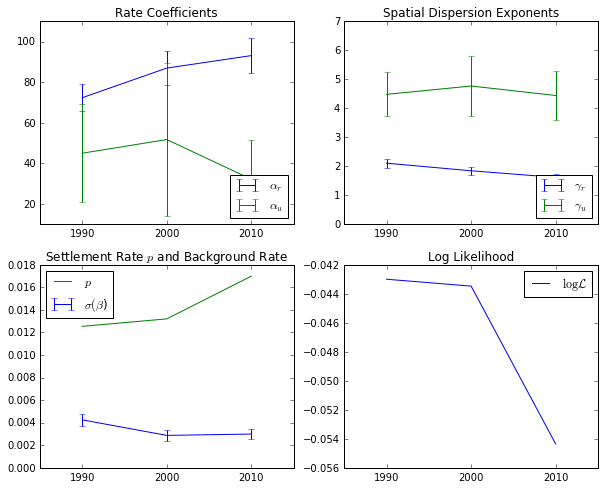

In [67]:
f, axs = plt.subplots(2, 2, figsize = (10, 8))


ax = axs[0][0]
ax.errorbar(maxes.Y0, pars[:,0], yerr = sigs[:,0], label = r'$\alpha_r$')
ax.errorbar(maxes.Y0, pars[:,1], yerr = sigs[:,1], label = r'$\alpha_u$')
ax.set(xlim = (1985, 2015))
ax.legend(loc = 4)
ax.set_title('Rate Coefficients')
ax.xaxis.set_ticks(maxes.Y0)

ax = axs[0][1]
ax.errorbar(maxes.Y0, pars[:,2], yerr = sigs[:,2], label = r'$\gamma_r$')
ax.errorbar(maxes.Y0, pars[:,3], yerr = sigs[:,3], label = r'$\gamma_u$')
ax.set(xlim = (1985, 2015), ylim = (0, 7))
ax.legend(loc = 4)
ax.set_title('Spatial Dispersion Exponents')
ax.xaxis.set_ticks(maxes.Y0)

ax = axs[1][0]
ax.errorbar(maxes.Y0, 
                expit(pars[:,4]), 
                yerr = expit(pars[:,4]) * expit(1 - pars[:,4]) * sigs[:,4],
                label = r'$\sigma(\beta$)')

def prop(i):
    X = maps[years[i+1]] - maps[years[i]]
    X[X < 0] = 0
    X = X.astype('float')
    X[maps[years[i]] == 1] = np.nan
    X[geo == 0] = np.nan

    return np.nanmean(X)
props = [prop(i) for i in range(3)]

ax.plot(maxes.Y0, props, label = r'$p$')

# axs[2].plot(maxes.Y0, expit(pars[:,4]), label = r'$\sigma(\beta)$')
ax.set(xlim = (1985, 2015))
ax.legend(loc = 2)
ax.set_title(r'Settlement Rate $p$ and Background Rate')
ax.xaxis.set_ticks(maxes.Y0)
ax.set(ylim = (0, max(props) + .001))

ax = axs[1][1]
ax.plot(maxes.Y0, maxes.ll, label = r'$\log \mathcal{L}$')

ax.set_title('Log Likelihood')
ax.legend(loc = 1)
t = ax.xaxis.set_ticks(maxes.Y0)
ax.set(xlim = (1985, 2015))

In [26]:
densities = {}
for i in range(len(maxes)):
    e = estimator(M0 = maps[years[i]], geo = geo, model = 'logistic')
    e.update_morphology()
    e.make_dist_array()
    e.partition_clusters([maxes['T'][i]])
    e.partition_dist_array()

    pars = {
        'alpha' : maxes.pars_hat[i][0:2],
        'gamma' : maxes.pars_hat[i][2:4],
        'beta' : maxes.pars_hat[i][4],
    }

    d = logistic_density(e, **pars)
    d[maps[years[i]] == 1] = np.nan
    d[geo == 0] = np.nan
    densities.update({i : d})
    

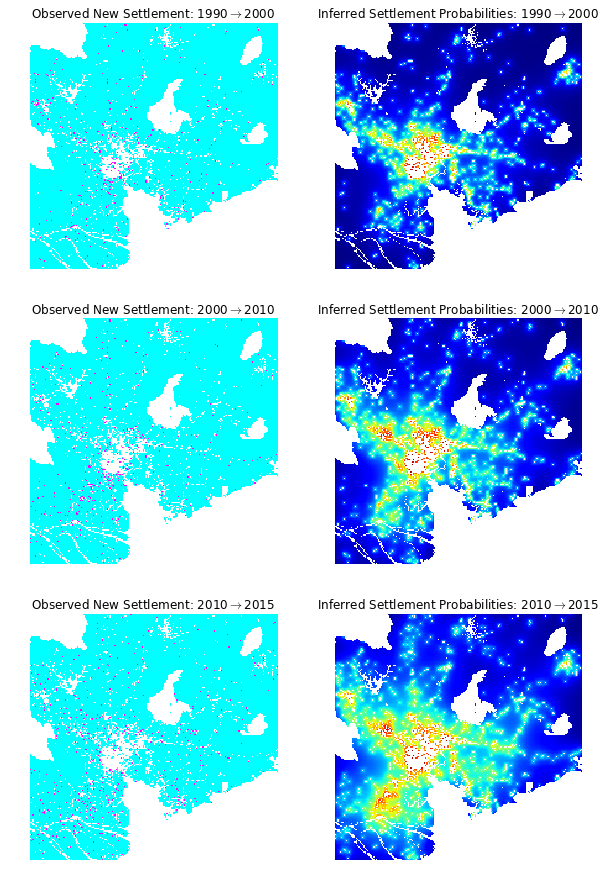

In [64]:
f, axs = plt.subplots(3, 2, figsize = (10, 15))

for i in range(len(maxes)):
    X = maps[years[i+1]] - maps[years[i]]
    X = X.astype('float64')
    X[geo == 0] = np.nan
    X[X < 0] = 0
    X[maps[years[i]] == 1] = np.nan
    im = axs[i][0].imshow(X, interpolation = 'nearest', cmap = 'cool')
    
    axs[i][0].set_title('Observed New Settlement: ' + str(years[i]) + r'$\rightarrow$' + str(years[i+1])) 
    axs[i][0].axis('off')
    
    im = axs[i][1].imshow(np.log(densities[i]), interpolation = 'nearest')
    axs[i][1].set_title('Inferred Settlement Probabilities: ' + str(years[i]) + r'$\rightarrow$' + str(years[i+1])) 
    axs[i][1].axis('off')

In [33]:
def bin_ent(i):
    X = maps[years[i+1]] - maps[years[i]]
    X[X < 0] = 0
    X = X.astype('float')
    X[maps[years[i]] == 1] = np.nan
    X[geo == 0] = np.nan

    p = np.nanmean(X)

    return p * np.log(p) + (1 - p) * np.log(1 - p)

def ll(i):
    return np.nanmean(densities[i] * np.log(densities[i]) + (1 - densities[i]) * np.log(1 - densities[i]))

be = [bin_ent(i) for i in np.arange(3)]
lls = [ll(i) for i in np.arange(3)]

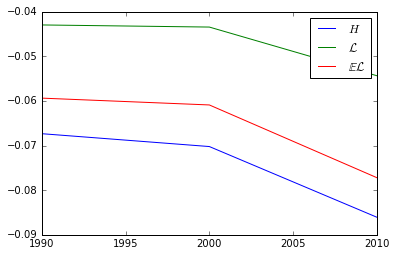

In [34]:
f = plt.figure(figsize = (6, 4))
ax = f.add_subplot(111)
ax.plot(maxes.Y0, be, label = r'$H$')
ax.plot(maxes.Y0, maxes.ll, label = r'$\mathcal{L}$')
ax.plot(maxes.Y0, lls, label = r'$\mathbb{E}\mathcal{L}$')
ax.legend()

In [35]:
def prop(i):
    X = maps[years[i+1]] - maps[years[i]]
    X[X < 0] = 0
    X = X.astype('float')
    X[maps[years[i]] == 1] = np.nan
    X[geo == 0] = np.nan

    return np.nanmean(X)